**Part 1:** Estimating the posterior distribution using different computational methods

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import beta,binom,norm

def makePlot(x,y,xlabel,ylabel,title):

  max_x = x[np.argmax(y)]
  max_x = np.round(max_x,5)
  max_y = np.max(y)
  plt.axvline(x=max_x, color='r', linestyle='--', label=f'Max f(x) at θ={max_x}')
  plt.annotate(f'Max at θ={max_x}', xy=(max_x, max_y), xytext=(max_x, max_y * 1.18),horizontalalignment='center')
  plt.plot(x, y, marker='.', linestyle='', color='b')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.grid(True)
  plt.show()


**Solution to 1.1:**

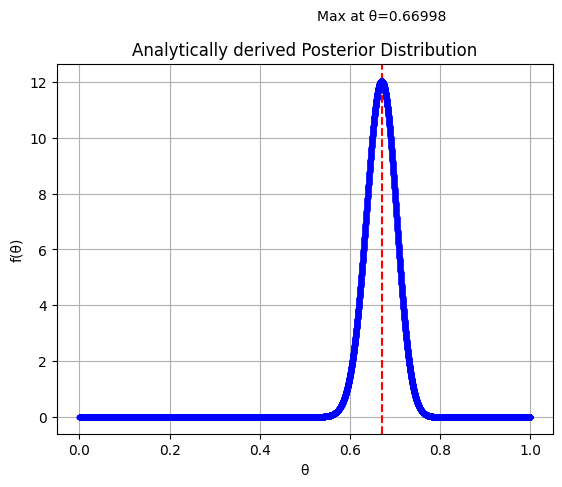

In [81]:
alpha = 135
beta_param = 67

theta_values = np.linspace(0, 1, 20000)

posterior_pdf_anal = beta.pdf(theta_values, alpha, beta_param)

makePlot(theta_values,posterior_pdf_anal,'θ','f(θ)','Analytically derived Posterior Distribution')

**Solution to 1.2:**

1.405675350632108e-10


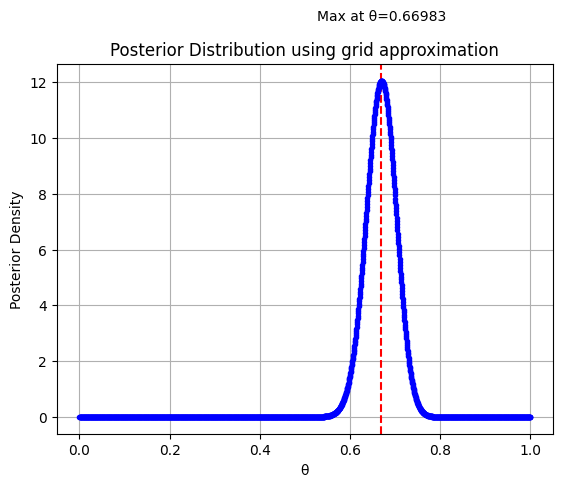

In [82]:
from scipy.special import comb

# Grid approximation

theta_grid = np.linspace(0, 1, 2000) #2000 grid points

# Prior distribution (Beta(1,1) is uniform)
prior = beta.pdf(theta_grid, 1, 1)

# Likelihood function for the given data
data = np.array([10, 15, 15, 14, 14, 14, 13, 11, 12, 16])
n = 20
likelihood = np.prod([comb(n,y) * theta_grid**y * (1 - theta_grid)**(n - y) for y in data], axis=0)

# Unnormalized posterior distribution
unnormalized_posterior = likelihood * prior

# Normalize the posterior
posterior_density_grid = unnormalized_posterior / np.mean(unnormalized_posterior)

print(np.mean(unnormalized_posterior))

makePlot(theta_grid,posterior_density_grid,'θ','Posterior Density','Posterior Distribution using grid approximation')



**Solution to 1.3:**

In [83]:
n = 20
a_prior = 1
b_prior = 1

num_samples = 5000

# Draw samples from the prior distribution Beta(1, 1)
theta_samples = beta.rvs(a_prior, b_prior, size=num_samples)

def likelihood(theta, data, n):
    return np.prod([binom.pmf(y, n, theta) for y in data])

likelihoods = np.array([likelihood(theta, data, n) for theta in theta_samples])

marginal_likelihood = np.mean(likelihoods)
print("Marginal likelihood using Monte Carlo Integration is: ", marginal_likelihood)


Marginal likelihood using Monte Carlo Integration is:  1.4847617670139002e-10


**Solution to 1.4:**

2664     0.553101
18285    0.691203
14376    0.651988
2408     0.684353
11921    0.702327
           ...   
12774    0.664420
997      0.707337
2340     0.659674
14763    0.609868
8935     0.706736
Name: theta, Length: 5000, dtype: float64



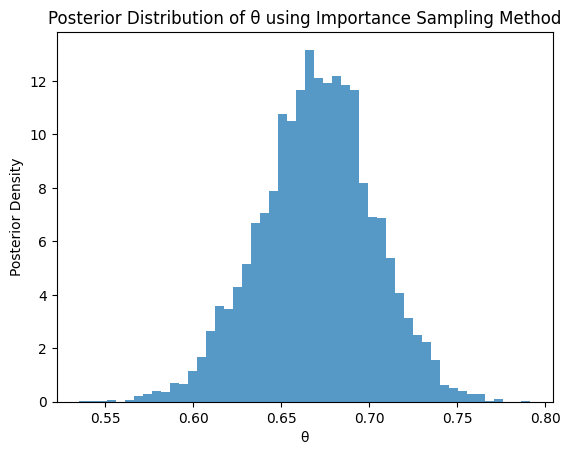

In [84]:
num_samples = 20000

# Proposal distribution: Normal distribution centered at the mean of the prior
proposal_mean = 0.5
proposal_std = 0.3

# Draw samples from the proposal distribution
theta_samples = np.clip(norm.rvs(proposal_mean, proposal_std, size=num_samples), 0, 1)

likelihoods = np.array([likelihood(theta, data, n) for theta in theta_samples])
priors = beta.pdf(theta_samples, a_prior, b_prior)
proposals = norm.pdf(theta_samples, proposal_mean, proposal_std)

weights = likelihoods * priors / proposals

# Creating a DataFrame to store the samples and their corresponding weights
df = pd.DataFrame({'theta': theta_samples, 'weights': weights})

# Normalize=ing the weights
df['weights'] /= df['weights'].sum()

# Sampling N/4 samples from the DataFrame based on their weights
posterior_samples_imp = df.sample(n=num_samples // 4, weights='weights', replace=True)

# Display the posterior samples
#print(posterior_samples.head())
print(posterior_samples_imp.theta)
print()

plt.hist(posterior_samples_imp.theta, bins=50, density=True, alpha=0.75)
plt.title('Posterior Distribution of θ using Importance Sampling Method')
plt.xlabel('θ')
plt.ylabel('Posterior Density')
plt.show()

**Solution to 1.5:**

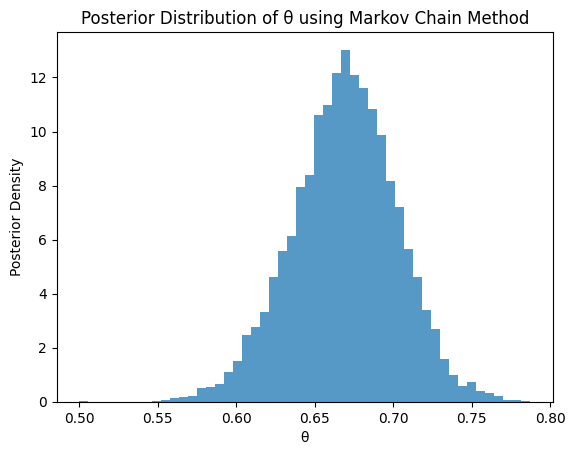

Mean of θ: 0.6689634582348565
Standard Deviation of θ: 0.03329303946913449


In [85]:
num_samples = 20000

def posterior(theta, data, n, a_prior, b_prior):
    if 0 <= theta <= 1:
        prior = beta.pdf(theta, a_prior, b_prior)
        likelihood_val = likelihood(theta, data, n)
        return likelihood_val * prior
    else:
        return 0

def metropolis_hastings(data, n, a_prior, b_prior, num_samples):
    samples = []
    current_theta = 0.5
    proposal_std = 0.05

    for i in range(num_samples):
        proposed_theta = norm.rvs(current_theta, proposal_std)
        acceptance_ratio = (posterior(proposed_theta, data, n, a_prior, b_prior) /
                            posterior(current_theta, data, n, a_prior, b_prior))

        if np.random.rand() < acceptance_ratio:
            current_theta = proposed_theta

        samples.append(current_theta)

    return np.array(samples)

posterior_samples_MC = metropolis_hastings(data, n, a_prior, b_prior, num_samples)

plt.hist(posterior_samples_MC, bins=50, density=True, alpha=0.75)
plt.title('Posterior Distribution of θ using Markov Chain Method')
plt.xlabel('θ')
plt.ylabel('Posterior Density')
plt.show()


mean_theta = np.mean(posterior_samples_MC)
std_theta = np.std(posterior_samples_MC)
print(f"Mean of θ: {mean_theta}")
print(f"Standard Deviation of θ: {std_theta}")


**Solution to 1.6:**

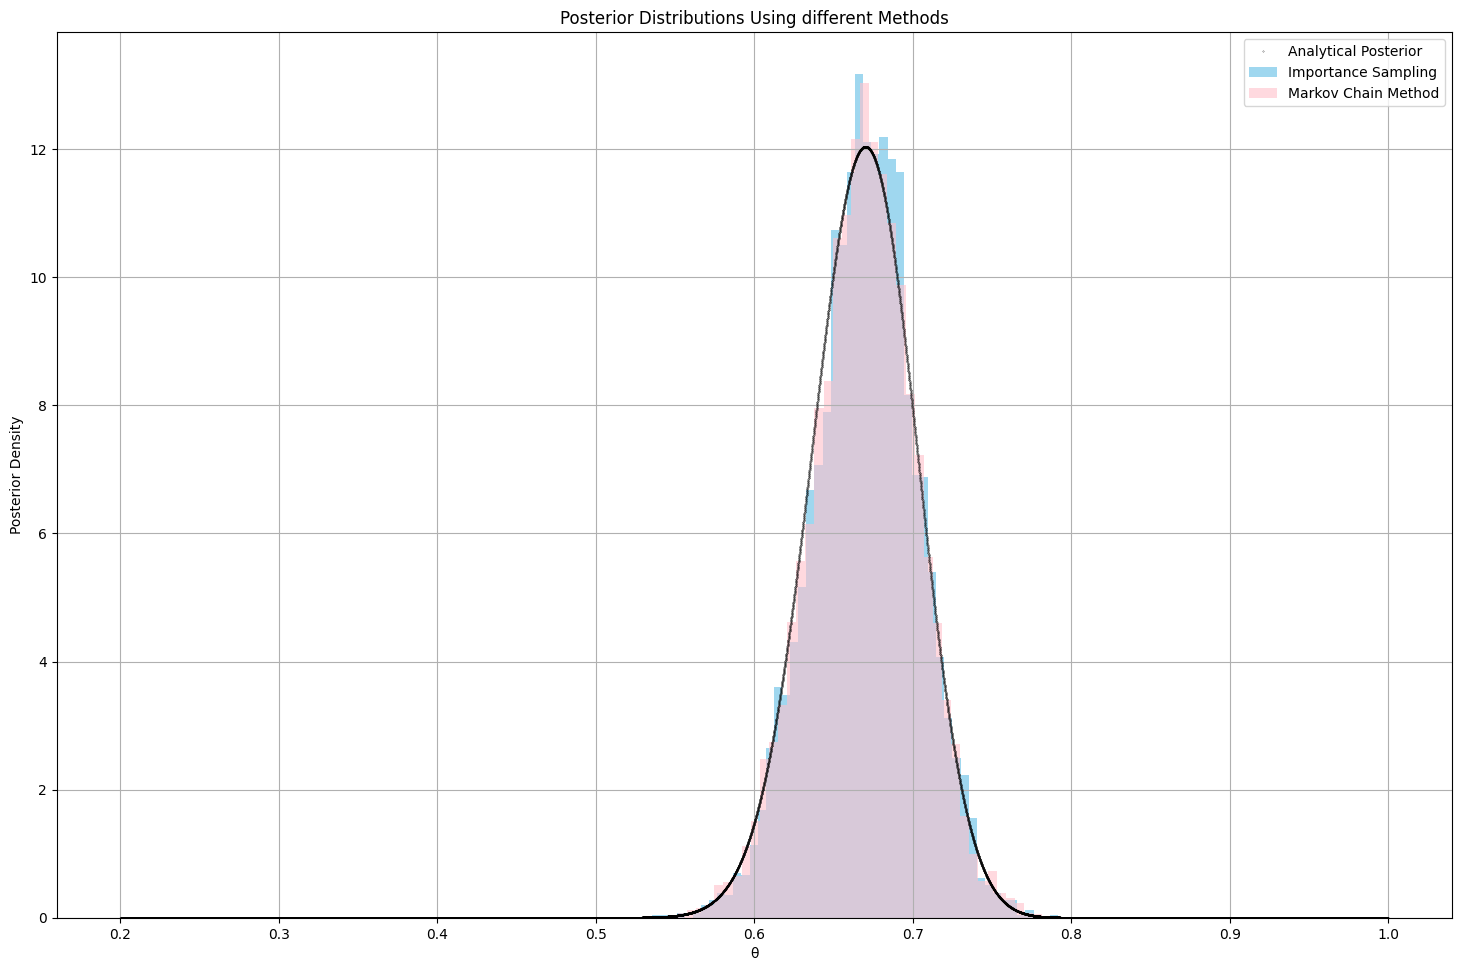

In [86]:

x = theta_values[4000:]
y =posterior_pdf_anal[4000:]
xlabel ='θ'
ylabel ='f(θ)'
title = 'Analytically derived Posterior Distribution'
plt.figure(figsize=(18,11.5))
plt.plot(x, y, marker='.', linestyle='', color='black', label = 'Analytical Posterior',markersize = 0.4)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.grid(True)


plt.hist(posterior_samples_imp.theta, bins=50, density=True, alpha=0.8, color='skyblue',label='Importance Sampling')
plt.hist(posterior_samples_MC, bins=50, density=True, alpha=0.6, color='pink',label='Markov Chain Method')
plt.title('Posterior Distributions Using different Methods')
plt.xlabel('θ')
plt.ylabel('Posterior Density')
plt.legend()
plt.show()



**Part 2:** Writing your own sampler for Bayesian inference

Solution to 2.5.1:


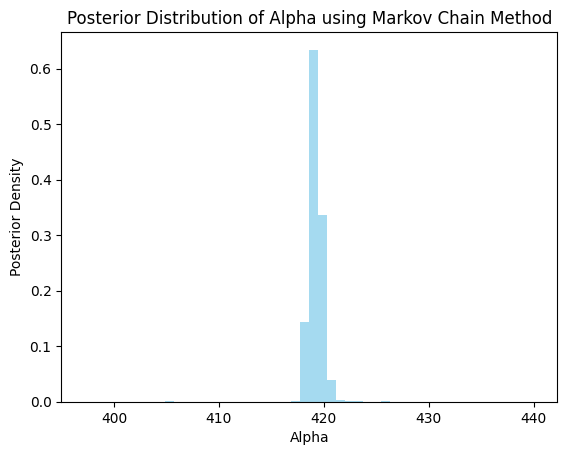

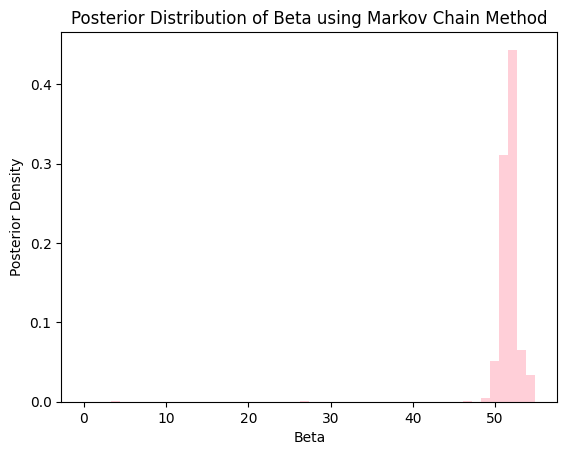

In [87]:
# Load the data
url = "https://raw.githubusercontent.com/yadavhimanshu059/CGS698C/main/notes/Data/word-recognition-times.csv"
dat = pd.read_csv(url)

# Convert 'type' column to binary values (0 for words, 1 for non-words)
dat["type_binary"] = (dat["type"] == "non-word").astype(int)

# Extract values from DataFrame columns
RT_values = dat["RT"].values
type_values = dat["type_binary"].values

# Define likelihood, prior, and unnormalized posterior
def likelihood(alpha, beta, sigma, RT, type_binary):
    mu = alpha + beta * type_binary
    return np.sum(-0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((RT - mu) / sigma)**2)

def prior_alpha(alpha):
    return -0.5 * ((alpha - 400) / 50)**2  # Normal prior with mean 400 and sd 50

def prior_beta(beta):
    if beta <= 0:
        return -np.inf  # Truncated normal, log density is -Infinity for beta <= 0
    else:
        return -0.5 * ((beta - 0) / 50)**2  # Truncated normal with mean 0 and sd 50

def log_posterior(alpha, beta, sigma, RT, type_binary):
    log_likelihood = likelihood(alpha, beta, sigma, RT, type_binary)
    log_prior_alpha = prior_alpha(alpha)
    log_prior_beta = prior_beta(beta)
    return log_likelihood + log_prior_alpha + log_prior_beta

# Metropolis-Hastings sampler
def metropolis_hastings(iterations, RT, type_binary, initial_alpha, initial_beta, proposal_sd=10):
    alpha_samples = [initial_alpha]
    beta_samples = [initial_beta]
    accepted = 0

    for _ in range(iterations):
        alpha_proposal = np.random.normal(alpha_samples[-1], proposal_sd)
        beta_proposal = np.random.normal(beta_samples[-1], proposal_sd)

        log_posterior_current = log_posterior(alpha_samples[-1], beta_samples[-1], 30, RT, type_binary)
        log_posterior_proposal = log_posterior(alpha_proposal, beta_proposal, 30, RT, type_binary)

        log_ratio = log_posterior_proposal - log_posterior_current

        if np.log(np.random.uniform()) < log_ratio:
            alpha_samples.append(alpha_proposal)
            beta_samples.append(beta_proposal)
            accepted += 1
        else:
            alpha_samples.append(alpha_samples[-1])
            beta_samples.append(beta_samples[-1])

    acceptance_rate = accepted / iterations
    return alpha_samples, beta_samples, acceptance_rate

# Initial values and hyperparameters
initial_alpha = 400
initial_beta = 0
iterations = 10000

# Run Metropolis-Hastings sampler
alpha_samples, beta_samples, acceptance_rate = metropolis_hastings(iterations, RT_values, type_values, initial_alpha, initial_beta)

plt.hist(alpha_samples, bins=50, density=True, alpha=0.75,color='skyblue')
plt.title('Posterior Distribution of Alpha using Markov Chain Method')
plt.xlabel('Alpha')
plt.ylabel('Posterior Density')
plt.show()


plt.hist(beta_samples,bins=50,density=True,alpha=0.75,color='pink')
plt.title('Posterior Distribution of Beta using Markov Chain Method')
plt.xlabel('Beta')
plt.ylabel('Posterior Density')
plt.show()

Solution to 2.5.1 and 2.5.2:

In [88]:
# Compute posterior estimates
alpha_est = np.mean(alpha_samples)
beta_est = np.mean(beta_samples)

# Output estimated parameters and acceptance rate
print("Estimated alpha:", alpha_est)
print("Estimated beta:", beta_est)
print("Acceptance rate:", acceptance_rate)


# Calculate 95% credible interval for alpha and beta
alpha_ci = np.quantile(alpha_samples, q=[0.025, 0.975])
beta_ci = np.quantile(beta_samples, q=[0.025, 0.975])

# Output credible intervals
print("95% Credible Interval for alpha:", alpha_ci)
print("95% Credible Interval for beta:", beta_ci)


Estimated alpha: 419.3234562830853
Estimated beta: 51.613931981885095
Acceptance rate: 0.0106
95% Credible Interval for alpha: [418.18477331 420.62591754]
95% Credible Interval for beta: [49.79473126 53.84413693]


**Part 3:**

Solution to 3.1:

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/hmc/hmc.py:152: RuntimeWarning: overflow encountered in exp
  accept_stat = min(1, np.exp(-energy_change))


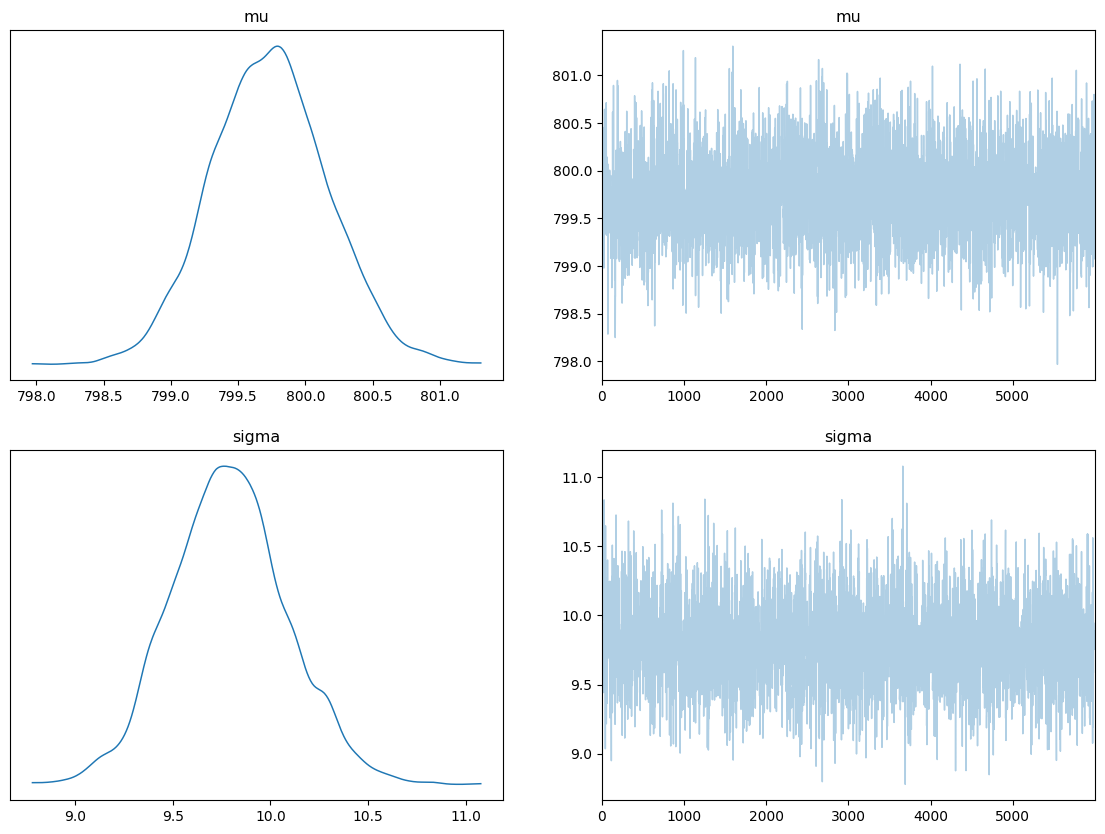

In [89]:
import pymc as pm

# Generate synthetic data
np.random.seed(0)
true_mu = 800
true_var = 100
y = np.random.normal(true_mu, np.sqrt(true_var), 500)

# Define the PyMC3 model
with pm.Model() as model:
    # Priors for µ and σ
    mu = pm.Normal('mu', mu=1000, sigma=100)
    sigma = pm.HalfNormal('sigma', sigma=2)

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # HMC sampler
    step = pm.HamiltonianMC(step_scale=0.02, path_length=12 * 0.02)

    # Initial values
    initvals = {'mu': 1000, 'sigma': 11}

    # Sample from the posterior
    trace = pm.sample(draws=6000, tune=2000, step=step, chains=1, initvals=initvals)

# Plot the posterior distributions
pm.plot_trace(trace, var_names=['mu', 'sigma'],figsize=(14,10))
plt.show()


Solution to 3.2:

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/hmc/hmc.py:152: RuntimeWarning: overflow encountered in exp
  accept_stat = min(1, np.exp(-energy_change))


/usr/local/lib/python3.10/dist-packages/pymc/step_methods/hmc/hmc.py:152: RuntimeWarning: overflow encountered in exp
  accept_stat = min(1, np.exp(-energy_change))


/usr/local/lib/python3.10/dist-packages/pymc/step_methods/hmc/hmc.py:152: RuntimeWarning: overflow encountered in exp
  accept_stat = min(1, np.exp(-energy_change))


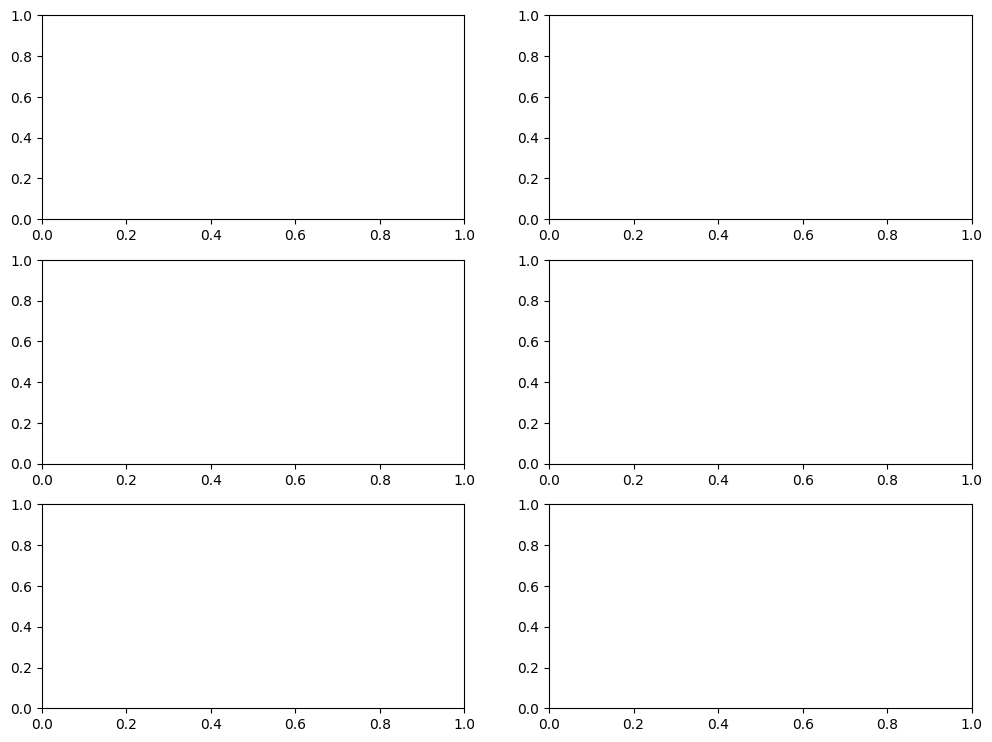

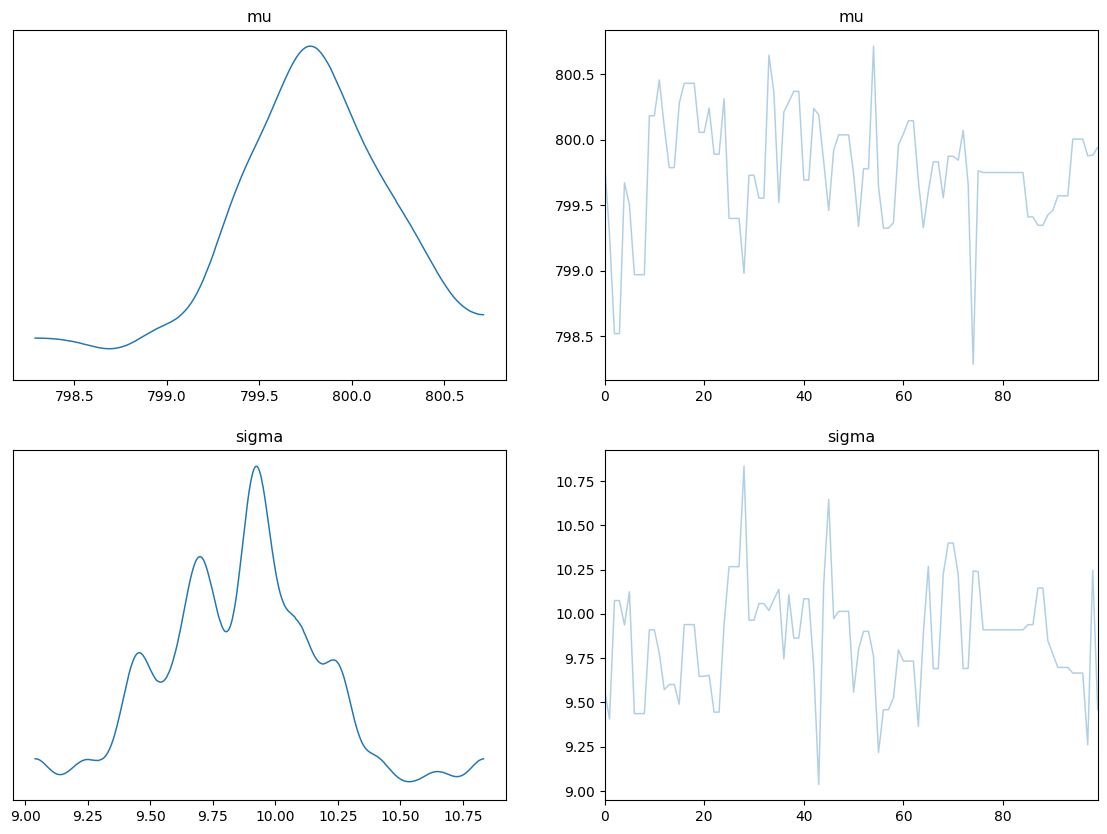

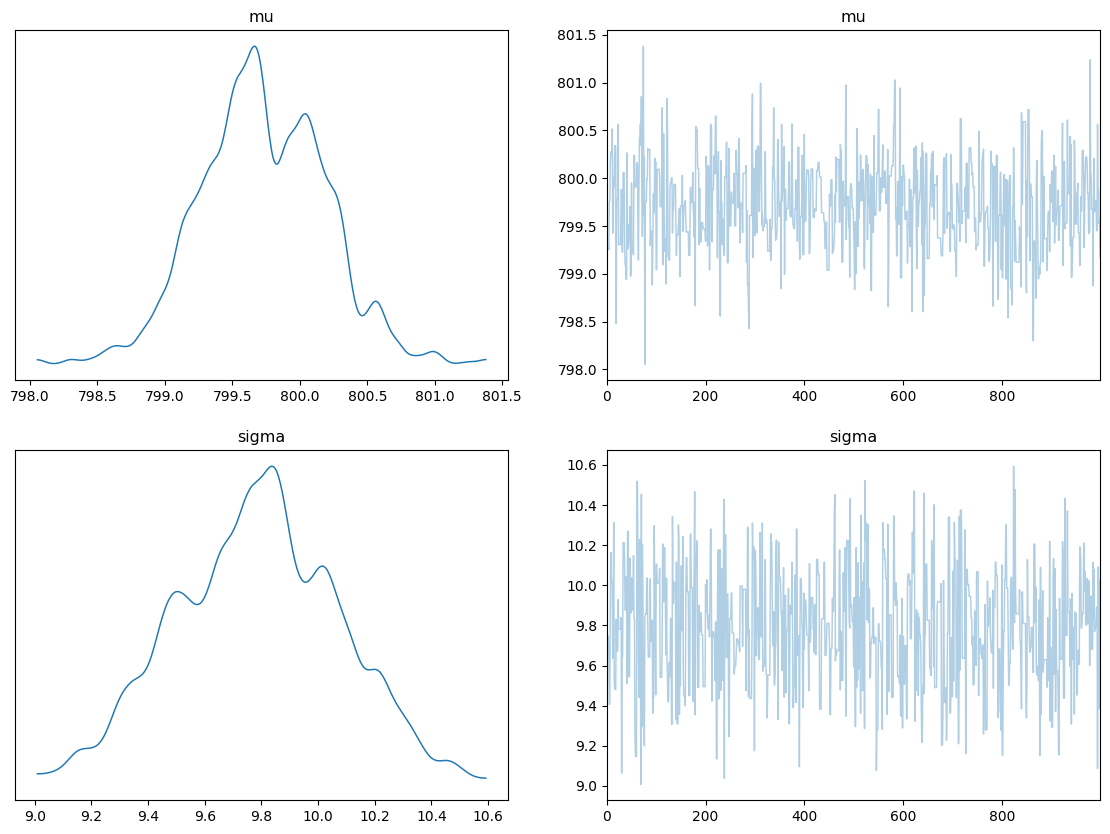

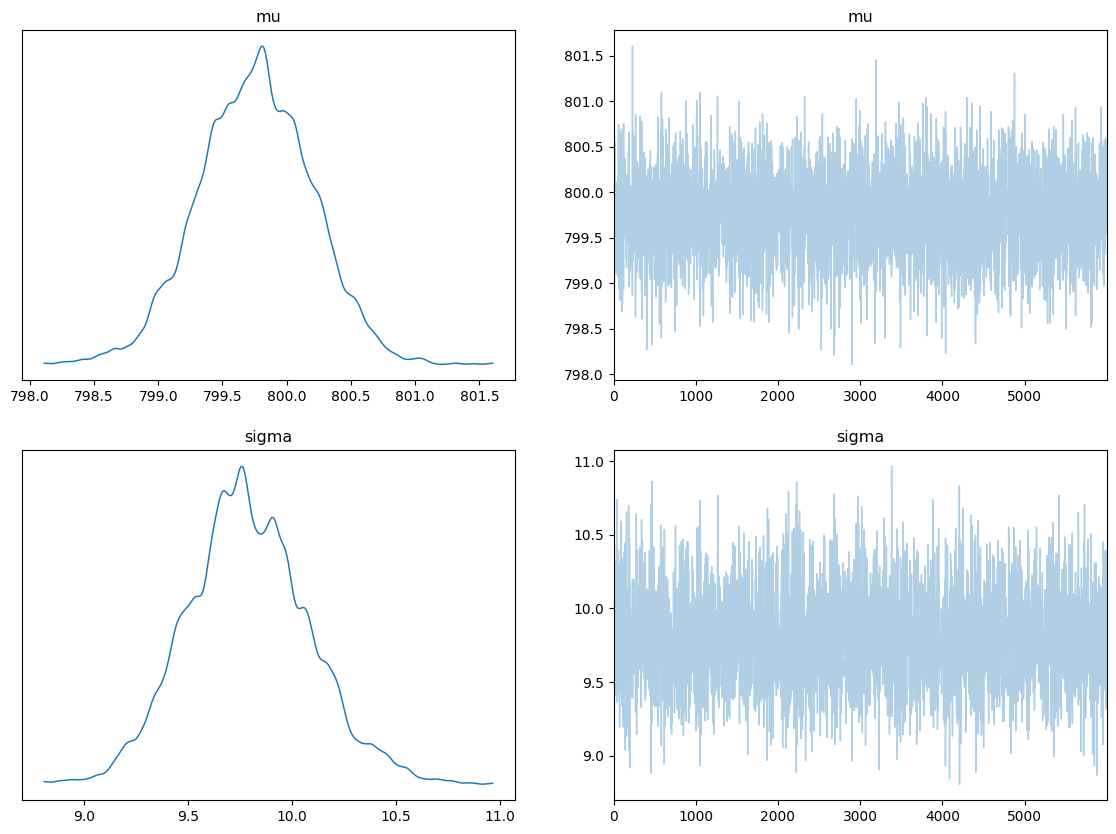

In [90]:


# Generate synthetic data
np.random.seed(0)
true_mu = 800
true_var = 100
y = np.random.normal(true_mu, np.sqrt(true_var), 500)

# Define a function to run the model and return the trace
def run_model(nsamp):
    with pm.Model() as model:
        # Priors for µ and σ
        mu = pm.Normal('mu', mu=1000, sigma=100)
        sigma = pm.HalfNormal('sigma', sigma=2)

        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

        step = pm.HamiltonianMC(step_scale=0.02, path_length=12 * 0.02)

        initvals = {'mu': 1000, 'sigma': 11}

        # Sample from the posterior
        trace = pm.sample(draws=nsamp, tune=2000, step=step, chains=1, initvals=initvals)

    return trace

nsamp_values = [100, 1000, 6000]
traces = {f'nsamp_{nsamp}': run_model(nsamp) for nsamp in nsamp_values}

# Plot the posterior distributions for comparison
fig, axes = plt.subplots(len(nsamp_values), 2, figsize=(12, 9), squeeze=False)

for i, (nsamp, trace) in enumerate(traces.items()):
    pm.plot_trace(trace, var_names=['mu', 'sigma'],figsize=(14,10))
    plt.show()


Solution to 3.3:

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/hmc/hmc.py:152: RuntimeWarning: overflow encountered in exp
  accept_stat = min(1, np.exp(-energy_change))


/usr/local/lib/python3.10/dist-packages/pymc/step_methods/hmc/hmc.py:152: RuntimeWarning: overflow encountered in exp
  accept_stat = min(1, np.exp(-energy_change))


/usr/local/lib/python3.10/dist-packages/pymc/step_methods/hmc/hmc.py:152: RuntimeWarning: overflow encountered in exp
  accept_stat = min(1, np.exp(-energy_change))


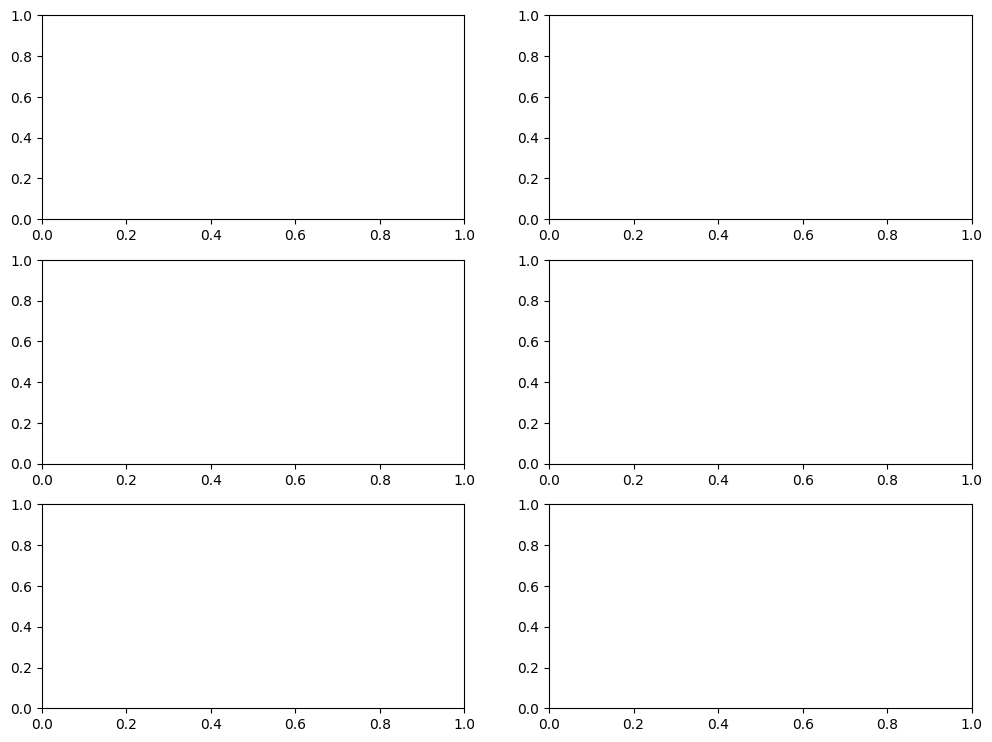

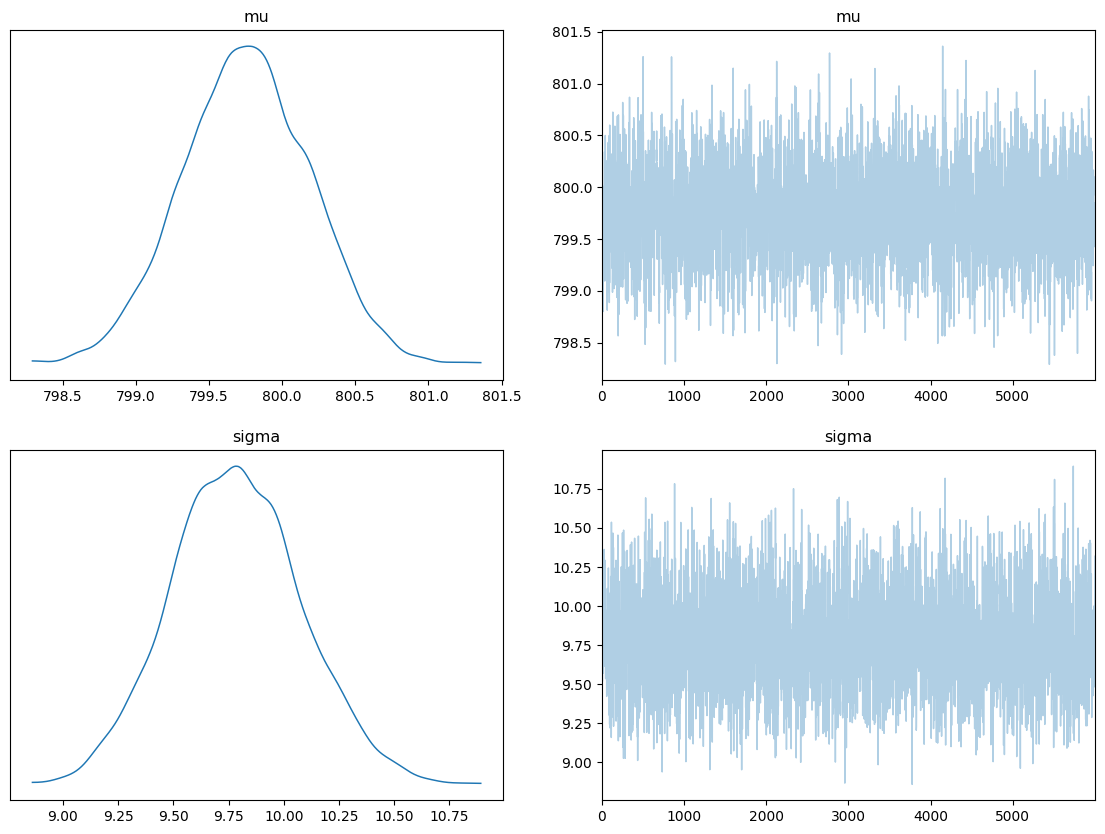

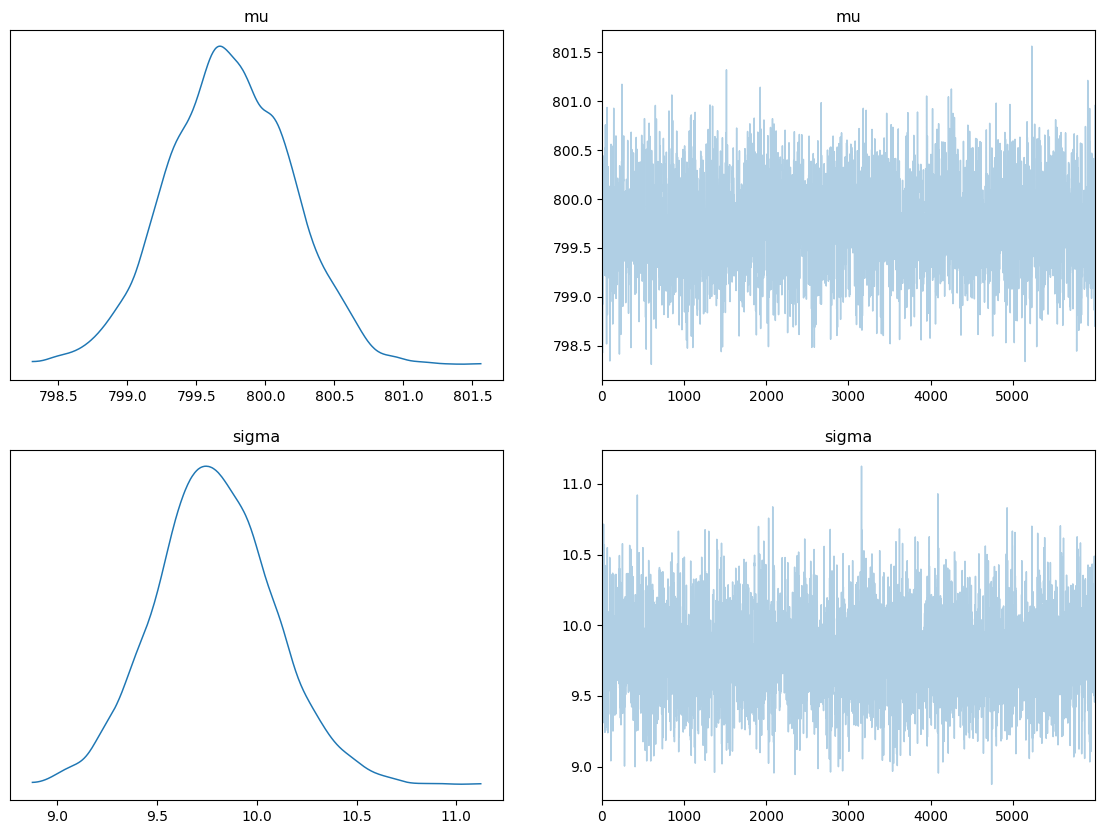

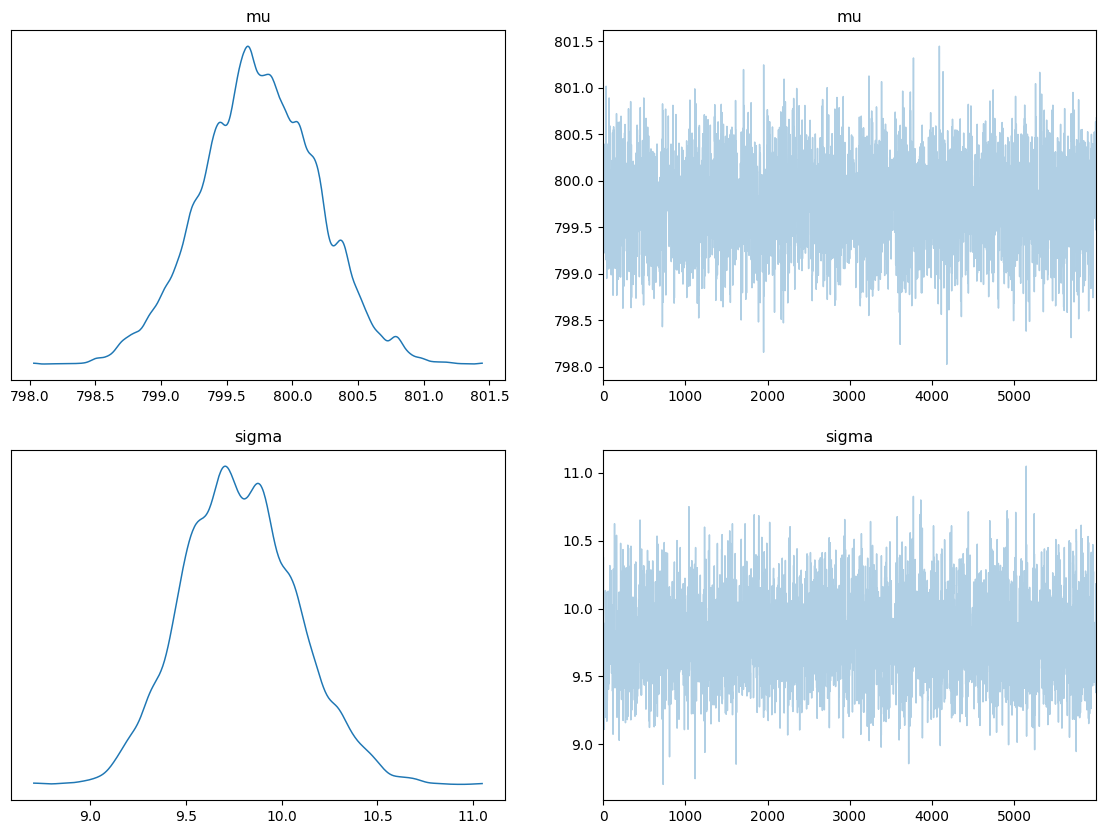

In [91]:
# Generate synthetic data
np.random.seed(0)
true_mu = 800
true_var = 100
y = np.random.normal(true_mu, np.sqrt(true_var), 500)

def run_model(step_size):
    with pm.Model() as model:
        # Priors for µ and σ
        mu = pm.Normal('mu', mu=1000, sigma=100)
        sigma = pm.HalfNormal('sigma', sigma=2)

        # Likelihood
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

        # HMC sampler
        step = pm.HamiltonianMC(step_scale=step_size, path_length=12 * step_size)

        # Initial values
        initvals = {'mu': 1000, 'sigma': 11}

        # Sample from the posterior
        trace = pm.sample(draws=6000, tune=2000, step=step, chains=1, initvals=initvals)

    return trace

# Run the model for different step sizes
step_sizes = [0.001, 0.005, 0.02]
traces = {f'step_{step_size}': run_model(step_size) for step_size in step_sizes}

# Plot the posterior distributions for comparison
fig, axes = plt.subplots(len(step_sizes), 2, figsize=(12, 9), squeeze=False)

for i, (step_size, trace) in enumerate(traces.items()):
    pm.plot_trace(trace, var_names=['mu', 'sigma'],figsize=(14,10))
    plt.show()


**Solution to 3.5:**

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/hmc/hmc.py:152: RuntimeWarning: overflow encountered in exp
  accept_stat = min(1, np.exp(-energy_change))


/usr/local/lib/python3.10/dist-packages/pymc/step_methods/hmc/hmc.py:152: RuntimeWarning: overflow encountered in exp
  accept_stat = min(1, np.exp(-energy_change))


/usr/local/lib/python3.10/dist-packages/pymc/step_methods/hmc/hmc.py:152: RuntimeWarning: overflow encountered in exp
  accept_stat = min(1, np.exp(-energy_change))


/usr/local/lib/python3.10/dist-packages/pymc/step_methods/hmc/hmc.py:152: RuntimeWarning: overflow encountered in exp
  accept_stat = min(1, np.exp(-energy_change))


/usr/local/lib/python3.10/dist-packages/pymc/step_methods/hmc/hmc.py:152: RuntimeWarning: overflow encountered in exp
  accept_stat = min(1, np.exp(-energy_change))


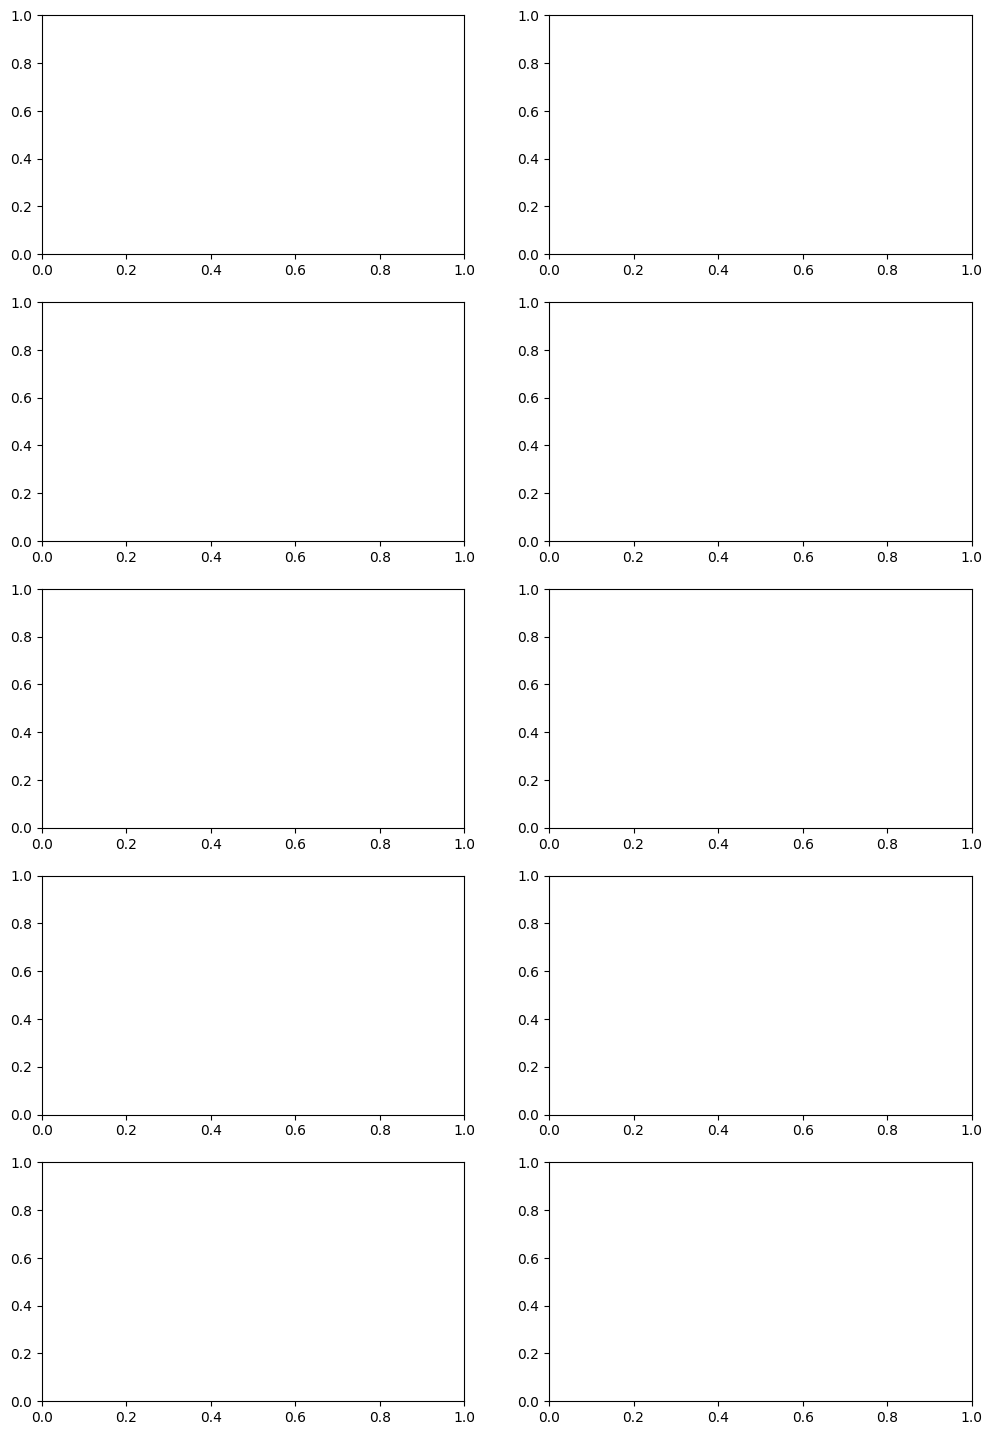

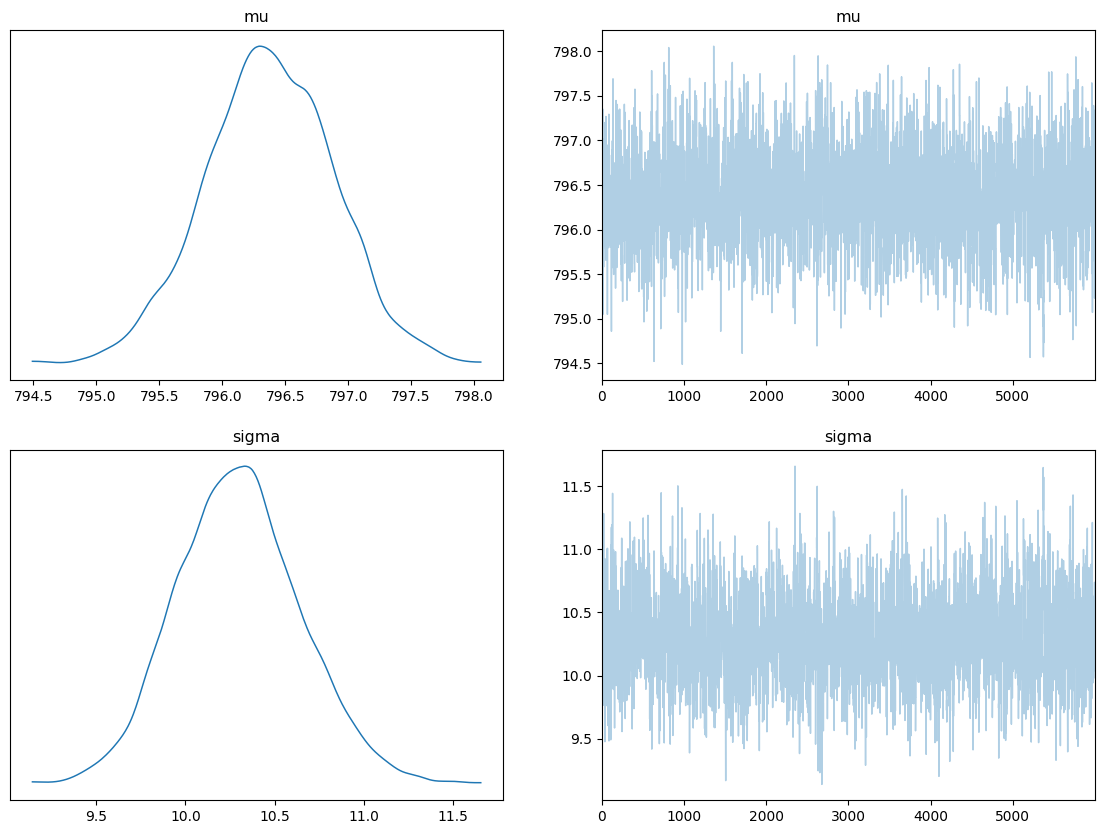

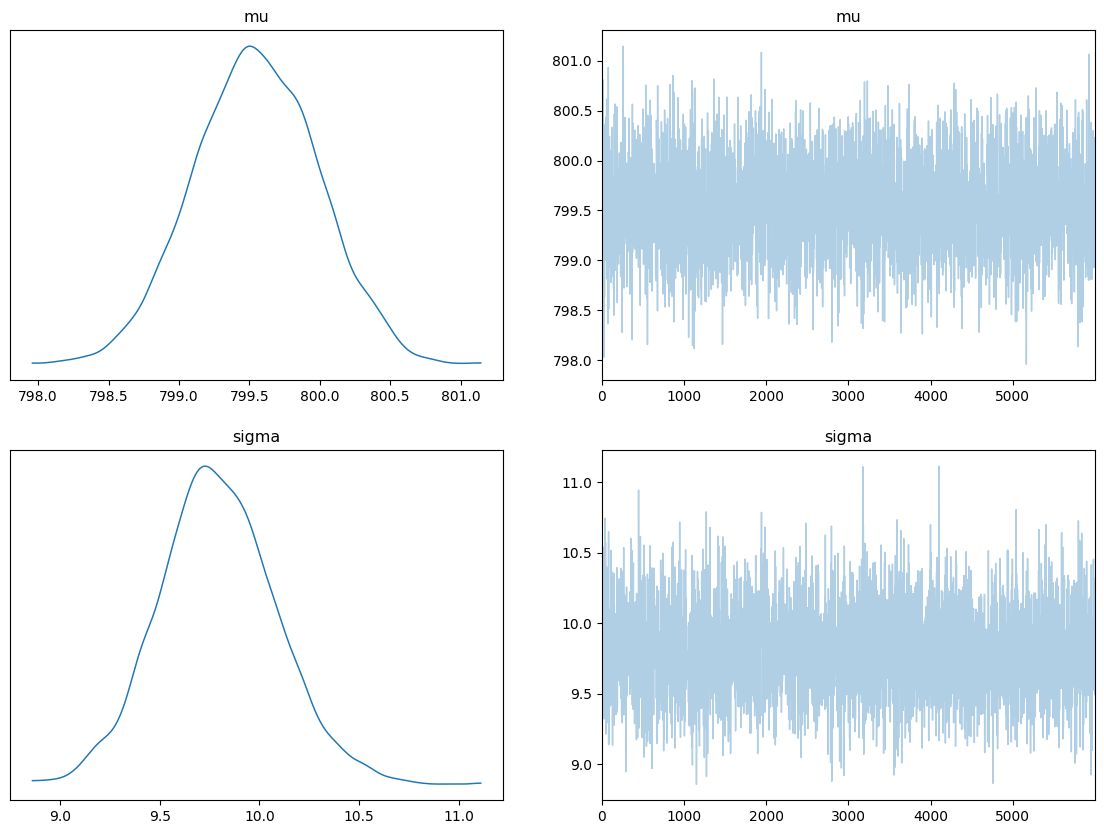

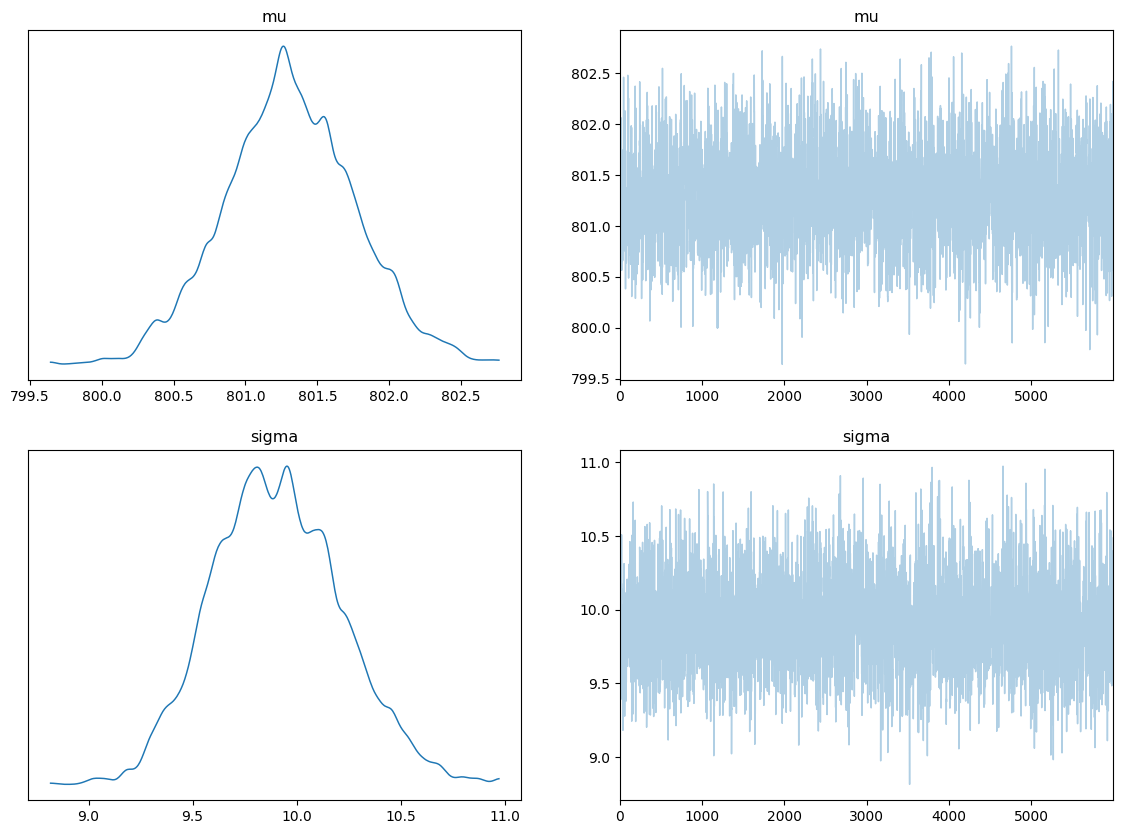

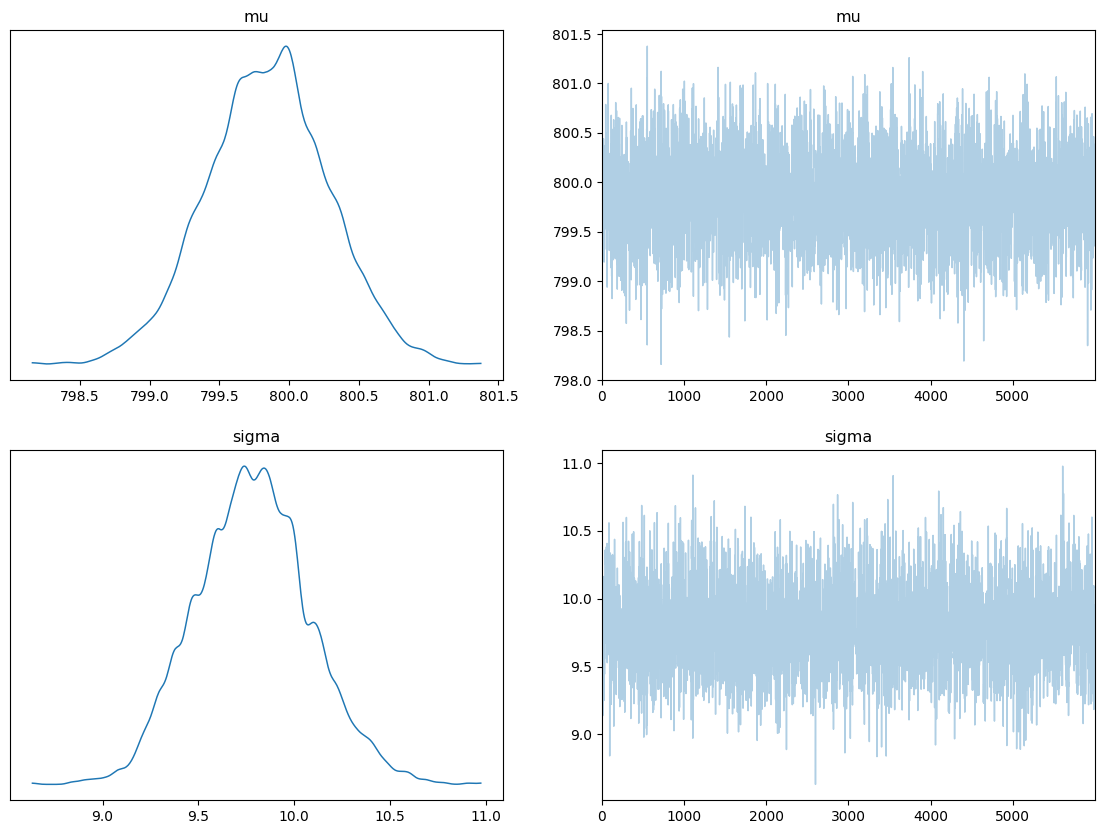

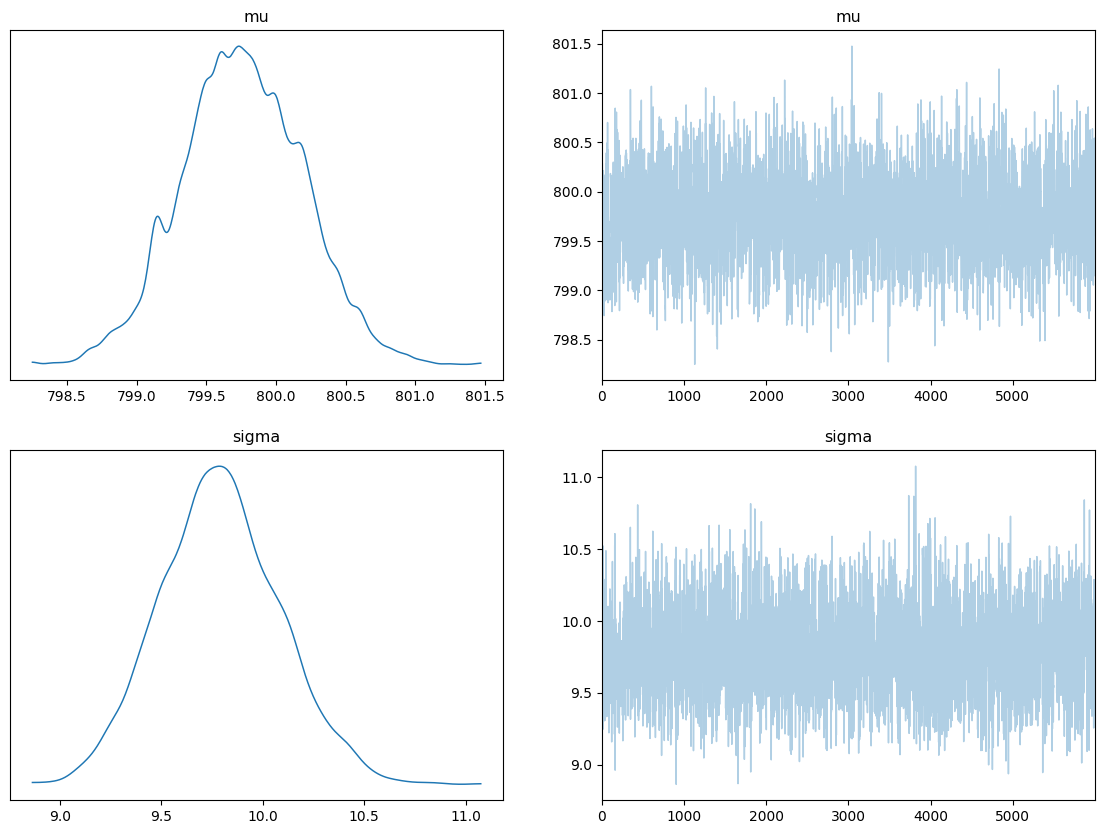

In [94]:


# Generate synthetic data
np.random.seed(0)
true_mu = 800
true_var = 100
y = np.random.normal(true_mu, np.sqrt(true_var), 500)

# Define a function to run the model and return the trace
def run_model(prior_mu_mean, prior_mu_sigma):
    with pm.Model() as model:
        # Priors for µ and σ
        mu = pm.Normal('mu', mu=prior_mu_mean, sigma=prior_mu_sigma)
        sigma = pm.HalfNormal('sigma', sigma=2)

        # Likelihood
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

        # HMC sampler
        step = pm.HamiltonianMC(step_scale=0.02, path_length=12 * 0.02)

        # Initial values
        initvals = {'mu': 1000, 'sigma': 11}

        # Sample from the posterior
        trace = pm.sample(draws=6000, tune=2000, step=step, chains=1, initvals=initvals)

    return trace

# Define different priors for µ
priors = [
    (400, 5),
    (400, 20),
    (1000, 5),
    (1000, 20),
    (1000, 100)
]

# Run the model for different priors on µ
traces = {f'prior_{mean}_{sigma}': run_model(mean, sigma) for mean, sigma in priors}

# Plot the posterior distributions for comparison
fig, axes = plt.subplots(len(priors), 2, figsize=(12, 18), squeeze=False)

for i, (step_size, trace) in enumerate(traces.items()):
    pm.plot_trace(trace, var_names=['mu', 'sigma'],figsize=(14,10))
    plt.show()
